In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

cudnn.benchmark = True
plt.ion()   # 대화형 모드

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# 2022.06.17-Changed for building ViG model
#            Huawei Technologies Co., Ltd. <foss@huawei.com>
# modified from https://github.com/facebookresearch/mae/blob/main/util/pos_embed.py
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
# --------------------------------------------------------
# Position embedding utils
# --------------------------------------------------------

import numpy as np

import torch

# --------------------------------------------------------
# relative position embedding
# References: https://arxiv.org/abs/2009.13658
# --------------------------------------------------------
def get_2d_relative_pos_embed(embed_dim, grid_size):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, grid_size*grid_size]
    """
    pos_embed = get_2d_sincos_pos_embed(embed_dim, grid_size)
    relative_pos = 2 * np.matmul(pos_embed, pos_embed.transpose()) / pos_embed.shape[1]
    return relative_pos


# --------------------------------------------------------
# 2D sine-cosine position embedding
# References:
# Transformer: https://github.com/tensorflow/models/blob/master/official/nlp/transformer/model_utils.py
# MoCo v3: https://github.com/facebookresearch/moco-v3
# --------------------------------------------------------
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

In [3]:
# 2022.06.17-Changed for building ViG model
#            Huawei Technologies Co., Ltd. <foss@huawei.com>
import math
import torch
from torch import nn
import torch.nn.functional as F


def pairwise_distance(x):
    """
    Compute pairwise distance of a point cloud.
    Args:
        x: tensor (batch_size, num_points, num_dims)
    Returns:
        pairwise distance: (batch_size, num_points, num_points)
    """
    with torch.no_grad():
        x_inner = -2*torch.matmul(x, x.transpose(2, 1))
        x_square = torch.sum(torch.mul(x, x), dim=-1, keepdim=True)
        return x_square + x_inner + x_square.transpose(2, 1)


def part_pairwise_distance(x, start_idx=0, end_idx=1):
    """
    Compute pairwise distance of a point cloud.
    Args:
        x: tensor (batch_size, num_points, num_dims)
    Returns:
        pairwise distance: (batch_size, num_points, num_points)
    """
    with torch.no_grad():
        x_part = x[:, start_idx:end_idx]
        x_square_part = torch.sum(torch.mul(x_part, x_part), dim=-1, keepdim=True)
        x_inner = -2*torch.matmul(x_part, x.transpose(2, 1))
        x_square = torch.sum(torch.mul(x, x), dim=-1, keepdim=True)
        return x_square_part + x_inner + x_square.transpose(2, 1)


def xy_pairwise_distance(x, y):
    """
    Compute pairwise distance of a point cloud.
    Args:
        x: tensor (batch_size, num_points, num_dims)
    Returns:
        pairwise distance: (batch_size, num_points, num_points)
    """
    with torch.no_grad():
        xy_inner = -2*torch.matmul(x, y.transpose(2, 1))
        x_square = torch.sum(torch.mul(x, x), dim=-1, keepdim=True)
        y_square = torch.sum(torch.mul(y, y), dim=-1, keepdim=True)
        return x_square + xy_inner + y_square.transpose(2, 1)


def dense_knn_matrix(x, k=16, relative_pos=None):
    """Get KNN based on the pairwise distance.
    Args:
        x: (batch_size, num_dims, num_points, 1)
        k: int
    Returns:
        nearest neighbors: (batch_size, num_points, k) (batch_size, num_points, k)
    """
    with torch.no_grad():
        x = x.transpose(2, 1).squeeze(-1)
        batch_size, n_points, n_dims = x.shape
        ### memory efficient implementation ###
        n_part = 10000
        if n_points > n_part:
            nn_idx_list = []
            groups = math.ceil(n_points / n_part)
            for i in range(groups):
                start_idx = n_part * i
                end_idx = min(n_points, n_part * (i + 1))
                dist = part_pairwise_distance(x.detach(), start_idx, end_idx)
                if relative_pos is not None:
                    dist += relative_pos[:, start_idx:end_idx]
                _, nn_idx_part = torch.topk(-dist, k=k)
                nn_idx_list += [nn_idx_part]
            nn_idx = torch.cat(nn_idx_list, dim=1)
        else:
            dist = pairwise_distance(x.detach())
            if relative_pos is not None:
                dist += relative_pos
            _, nn_idx = torch.topk(-dist, k=k) # b, n, k
        ######
        center_idx = torch.arange(0, n_points, device=x.device).repeat(batch_size, k, 1).transpose(2, 1)
    return torch.stack((nn_idx, center_idx), dim=0)


def xy_dense_knn_matrix(x, y, k=16, relative_pos=None):
    """Get KNN based on the pairwise distance.
    Args:
        x: (batch_size, num_dims, num_points, 1)
        k: int
    Returns:
        nearest neighbors: (batch_size, num_points, k) (batch_size, num_points, k)
    """
    with torch.no_grad():
        x = x.transpose(2, 1).squeeze(-1)
        y = y.transpose(2, 1).squeeze(-1)
        batch_size, n_points, n_dims = x.shape
        dist = xy_pairwise_distance(x.detach(), y.detach())
        if relative_pos is not None:
            dist += relative_pos
        _, nn_idx = torch.topk(-dist, k=k)
        center_idx = torch.arange(0, n_points, device=x.device).repeat(batch_size, k, 1).transpose(2, 1)
    return torch.stack((nn_idx, center_idx), dim=0)


class DenseDilated(nn.Module):
    """
    Find dilated neighbor from neighbor list

    edge_index: (2, batch_size, num_points, k)
    """
    def __init__(self, k=9, dilation=1, stochastic=False, epsilon=0.0):
        super(DenseDilated, self).__init__()
        self.dilation = dilation
        self.stochastic = stochastic
        self.epsilon = epsilon
        self.k = k

    def forward(self, edge_index):
        if self.stochastic:
            if torch.rand(1) < self.epsilon and self.training:
                num = self.k * self.dilation
                randnum = torch.randperm(num)[:self.k]
                edge_index = edge_index[:, :, :, randnum]
            else:
                edge_index = edge_index[:, :, :, ::self.dilation]
        else:
            edge_index = edge_index[:, :, :, ::self.dilation]
        return edge_index


class DenseDilatedKnnGraph(nn.Module):
    """
    Find the neighbors' indices based on dilated knn
    """
    def __init__(self, k=9, dilation=1, stochastic=False, epsilon=0.0):
        super(DenseDilatedKnnGraph, self).__init__()
        self.dilation = dilation
        self.stochastic = stochastic
        self.epsilon = epsilon
        self.k = k
        self._dilated = DenseDilated(k, dilation, stochastic, epsilon)

    def forward(self, x, y=None, relative_pos=None):
        if y is not None:
            #### normalize
            x = F.normalize(x, p=2.0, dim=1)
            y = F.normalize(y, p=2.0, dim=1)
            ####
            edge_index = xy_dense_knn_matrix(x, y, self.k * self.dilation, relative_pos)
        else:
            #### normalize
            x = F.normalize(x, p=2.0, dim=1)
            ####
            edge_index = dense_knn_matrix(x, self.k * self.dilation, relative_pos)
        return self._dilated(edge_index)

In [4]:
# 2022.06.17-Changed for building ViG model
#            Huawei Technologies Co., Ltd. <foss@huawei.com>
import torch
from torch import nn
from torch.nn import Sequential as Seq, Linear as Lin, Conv2d


##############################
#    Basic layers
##############################
def act_layer(act, inplace=False, neg_slope=0.2, n_prelu=1):
    # activation layer

    act = act.lower()
    if act == 'relu':
        layer = nn.ReLU(inplace)
    elif act == 'leakyrelu':
        layer = nn.LeakyReLU(neg_slope, inplace)
    elif act == 'prelu':
        layer = nn.PReLU(num_parameters=n_prelu, init=neg_slope)
    elif act == 'gelu':
        layer = nn.GELU()
    elif act == 'hswish':
        layer = nn.Hardswish(inplace)
    else:
        raise NotImplementedError('activation layer [%s] is not found' % act)
    return layer


def norm_layer(norm, nc):
    # normalization layer 2d
    norm = norm.lower()
    if norm == 'batch':
        layer = nn.BatchNorm2d(nc, affine=True)
    elif norm == 'instance':
        layer = nn.InstanceNorm2d(nc, affine=False)
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm)
    return layer


class MLP(Seq):
    def __init__(self, channels, act='relu', norm=None, bias=True):
        m = []
        for i in range(1, len(channels)):
            m.append(Lin(channels[i - 1], channels[i], bias))
            if act is not None and act.lower() != 'none':
                m.append(act_layer(act))
            if norm is not None and norm.lower() != 'none':
                m.append(norm_layer(norm, channels[-1]))
        super(MLP, self).__init__(*m)


class BasicConv(Seq):
    def __init__(self, channels, act='relu', norm=None, bias=True, drop=0.):
        m = []
        for i in range(1, len(channels)):
            m.append(Conv2d(channels[i - 1], channels[i], 1, bias=bias, groups=4))
            if norm is not None and norm.lower() != 'none':
                m.append(norm_layer(norm, channels[-1]))
            if act is not None and act.lower() != 'none':
                m.append(act_layer(act))
            if drop > 0:
                m.append(nn.Dropout2d(drop))

        super(BasicConv, self).__init__(*m)

        self.reset_parameters()

    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.InstanceNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


def batched_index_select(x, idx):
    r"""fetches neighbors features from a given neighbor idx

    Args:
        x (Tensor): input feature Tensor
                :math:`\mathbf{X} \in \mathbb{R}^{B \times C \times N \times 1}`.
        idx (Tensor): edge_idx
                :math:`\mathbf{X} \in \mathbb{R}^{B \times N \times l}`.
    Returns:
        Tensor: output neighbors features
            :math:`\mathbf{X} \in \mathbb{R}^{B \times C \times N \times k}`.
    """
    batch_size, num_dims, num_vertices_reduced = x.shape[:3]
    _, num_vertices, k = idx.shape
    idx_base = torch.arange(0, batch_size, device=idx.device).view(-1, 1, 1) * num_vertices_reduced
    idx = idx + idx_base
    idx = idx.contiguous().view(-1)

    x = x.transpose(2, 1)
    feature = x.contiguous().view(batch_size * num_vertices_reduced, -1)[idx, :]
    feature = feature.view(batch_size, num_vertices, k, num_dims).permute(0, 3, 1, 2).contiguous()
    return feature

In [17]:
# 2022.06.17-Changed for building ViG model
#            Huawei Technologies Co., Ltd. <foss@huawei.com>
import numpy as np
import torch
from torch import nn
# from .torch_nn import BasicConv, batched_index_select, act_layer
# from .torch_edge import DenseDilatedKnnGraph
# from .pos_embed import get_2d_relative_pos_embed
import torch.nn.functional as F
from timm.models.layers import DropPath


class MRConv2d(nn.Module):
    """
    Max-Relative Graph Convolution (Paper: https://arxiv.org/abs/1904.03751) for dense data type
    """
    def __init__(self, in_channels, out_channels, act='relu', norm=None, bias=True):
        super(MRConv2d, self).__init__()
        self.nn = BasicConv([in_channels*2, out_channels], act, norm, bias)

    def forward(self, x, edge_index, y=None):
        x_i = batched_index_select(x, edge_index[1])
        if y is not None:
            x_j = batched_index_select(y, edge_index[0])
        else:
            x_j = batched_index_select(x, edge_index[0])
        x_j, _ = torch.max(x_j - x_i, -1, keepdim=True)
        b, c, n, _ = x.shape
        x = torch.cat([x.unsqueeze(2), x_j.unsqueeze(2)], dim=2).reshape(b, 2 * c, n, _)
        return self.nn(x)


class EdgeConv2d(nn.Module):
    """
    Edge convolution layer (with activation, batch normalization) for dense data type
    """
    def __init__(self, in_channels, out_channels, act='relu', norm=None, bias=True):
        super(EdgeConv2d, self).__init__()
        self.nn = BasicConv([in_channels * 2, out_channels], act, norm, bias)

    def forward(self, x, edge_index, y=None):
        x_i = batched_index_select(x, edge_index[1])
        if y is not None:
            x_j = batched_index_select(y, edge_index[0])
        else:
            x_j = batched_index_select(x, edge_index[0])
        max_value, _ = torch.max(self.nn(torch.cat([x_i, x_j - x_i], dim=1)), -1, keepdim=True)
        return max_value


class GraphSAGE(nn.Module):
    """
    GraphSAGE Graph Convolution (Paper: https://arxiv.org/abs/1706.02216) for dense data type
    """
    def __init__(self, in_channels, out_channels, act='relu', norm=None, bias=True):
        super(GraphSAGE, self).__init__()
        self.nn1 = BasicConv([in_channels, in_channels], act, norm, bias)
        self.nn2 = BasicConv([in_channels*2, out_channels], act, norm, bias)

    def forward(self, x, edge_index, y=None):
        if y is not None:
            x_j = batched_index_select(y, edge_index[0])
        else:
            x_j = batched_index_select(x, edge_index[0])
        x_j, _ = torch.max(self.nn1(x_j), -1, keepdim=True)
        return self.nn2(torch.cat([x, x_j], dim=1))


class GINConv2d(nn.Module):
    """
    GIN Graph Convolution (Paper: https://arxiv.org/abs/1810.00826) for dense data type
    """
    def __init__(self, in_channels, out_channels, act='relu', norm=None, bias=True):
        super(GINConv2d, self).__init__()
        self.nn = BasicConv([in_channels, out_channels], act, norm, bias)
        eps_init = 0.0
        self.eps = nn.Parameter(torch.Tensor([eps_init]))

    def forward(self, x, edge_index, y=None):
        if y is not None:
            x_j = batched_index_select(y, edge_index[0])
        else:
            x_j = batched_index_select(x, edge_index[0])
        x_j = torch.sum(x_j, -1, keepdim=True)
        return self.nn((1 + self.eps) * x + x_j)


class GraphConv2d(nn.Module):
    """
    Static graph convolution layer
    """
    def __init__(self, in_channels, out_channels, conv='edge', act='relu', norm=None, bias=True):
        super(GraphConv2d, self).__init__()
        if conv == 'edge':
            self.gconv = EdgeConv2d(in_channels, out_channels, act, norm, bias)
        elif conv == 'mr':
            self.gconv = MRConv2d(in_channels, out_channels, act, norm, bias)
        elif conv == 'sage':
            self.gconv = GraphSAGE(in_channels, out_channels, act, norm, bias)
        elif conv == 'gin':
            self.gconv = GINConv2d(in_channels, out_channels, act, norm, bias)
        else:
            raise NotImplementedError('conv:{} is not supported'.format(conv))

    def forward(self, x, edge_index, y=None):
        return self.gconv(x, edge_index, y)


class DyGraphConv2d(GraphConv2d):
    """
    Dynamic graph convolution layer
    """
    def __init__(self, in_channels, out_channels, kernel_size=9, dilation=1, conv='edge', act='relu',
                 norm=None, bias=True, stochastic=False, epsilon=0.0, r=1):
        super(DyGraphConv2d, self).__init__(in_channels, out_channels, conv, act, norm, bias)
        self.k = kernel_size
        self.d = dilation
        self.r = r
        self.dilated_knn_graph = DenseDilatedKnnGraph(kernel_size, dilation, stochastic, epsilon)

    def forward(self, x, relative_pos=None):
        B, C, H, W = x.shape
        y = None
        if self.r > 1:
            y = F.avg_pool2d(x, self.r, self.r)
            y = y.reshape(B, C, -1, 1).contiguous()            
        x = x.reshape(B, C, -1, 1).contiguous()
        edge_index = self.dilated_knn_graph(x, y, relative_pos)
        x = super(DyGraphConv2d, self).forward(x, edge_index, y)
        return x.reshape(B, -1, H, W).contiguous()


class Grapher(nn.Module):
    """
    Grapher module with graph convolution and fc layers
    """
    def __init__(self, in_channels, kernel_size=9, dilation=1, conv='edge', act='relu', norm=None,
                 bias=True,  stochastic=False, epsilon=0.0, r=1, n=196, drop_path=0.0, relative_pos=False, LPE=False):
        super(Grapher, self).__init__()
        self.channels = in_channels
        self.n = n
        self.r = r
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(in_channels),
        )
        self.graph_conv = DyGraphConv2d(in_channels, in_channels * 2, kernel_size, dilation, conv,
                              act, norm, bias, stochastic, epsilon, r)
        self.fc2 = nn.Sequential(
            nn.Conv2d(in_channels * 2, in_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(in_channels),
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.relative_pos = None
        self.LPE = None

        if relative_pos:
            print('using relative_pos')
            relative_pos_tensor = torch.from_numpy(np.float32(get_2d_relative_pos_embed(in_channels,
                int(n**0.5)))).unsqueeze(0).unsqueeze(1)
            relative_pos_tensor = F.interpolate(
                    relative_pos_tensor, size=(n, n//(r*r)), mode='bicubic', align_corners=False)
            self.relative_pos = nn.Parameter(-relative_pos_tensor.squeeze(1), requires_grad=False)
        if LPE:
            print('using Learnable Positional Embedding')
            LPE_tensor = torch.from_numpy(np.float32(get_2d_sincos_pos_embed(in_channels,
                int(n**0.5)))).unsqueeze(0).unsqueeze(1)
            LPE_tensor = F.interpolate(
                    LPE_tensor, size=(n, n//(r*r)), mode='bilinear', align_corners=False)
            self.LPE_tensor = nn.Parameter(-LPE_tensor.squeeze(1), requires_grad=False)

    def _get_relative_pos(self, relative_pos, H, W):
        if relative_pos is None or H * W == self.n:
            return relative_pos
        else:
            N = H * W
            N_reduced = N // (self.r * self.r)
            return F.interpolate(relative_pos.unsqueeze(0), size=(N, N_reduced), mode="bicubic").squeeze(0)

    def _get_LPE(self, LPE, H, W):
        if LPE is None or H * W == self.n:
            return LPE
        else:
            N = H * W
            N_reduced = N // (self.r * self.r)
            return F.interpolate(LPE.unsqueeze(0), size=(N, N_reduced), mode="bicubic").squeeze(0)

    def forward(self, x):
        _tmp = x
        x = self.fc1(x)
        B, C, H, W = x.shape
        relative_pos = self._get_relative_pos(self.relative_pos, H, W)
        LPE = self._get_LPE(self.LPE, H, W)
        # x = self.graph_conv(x, relative_pos)
        x = self.graph_conv(x, LPE)
        x = self.fc2(x)
        x = self.drop_path(x) + _tmp
        return x

In [ ]:
## 2022.06.17-Changed for building ViG model
#            Huawei Technologies Co., Ltd. <foss@huawei.com>
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential as Seq

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model

# from gcn_lib import Grapher, act_layer


def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic',
        'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head',
        **kwargs
    }


default_cfgs = {
    'vig_224_gelu': _cfg(
        mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5),
    ),
    'vig_b_224_gelu': _cfg(
        crop_pct=0.95, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5),
    ),
}


class FFN(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act='relu', drop_path=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_features, hidden_features, 1, stride=1, padding=0),
            nn.BatchNorm2d(hidden_features),
        )
        self.act = act_layer(act)
        self.fc2 = nn.Sequential(
            nn.Conv2d(hidden_features, out_features, 1, stride=1, padding=0),
            nn.BatchNorm2d(out_features),
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        shortcut = x
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.drop_path(x) + shortcut
        return x#.reshape(B, C, N, 1)


class Stem(nn.Module):
    """ Image to Visual Embedding
    Overlap: https://arxiv.org/pdf/2106.13797.pdf
    """
    def __init__(self, img_size=224, in_dim=3, out_dim=768, act='relu'):
        super().__init__()        
        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, out_dim//2, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim//2),
            act_layer(act),
            nn.Conv2d(out_dim//2, out_dim, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim),
            act_layer(act),
            nn.Conv2d(out_dim, out_dim, 3, stride=1, padding=1),
            nn.BatchNorm2d(out_dim),
        )

    def forward(self, x):
        x = self.convs(x)
        return x


class Downsample(nn.Module):
    """ Convolution-based downsample
    """
    def __init__(self, in_dim=3, out_dim=768):
        super().__init__()        
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class DeepGCN(torch.nn.Module):
    def __init__(self, opt):
        super(DeepGCN, self).__init__()
        print(opt)
        k = opt.k
        act = opt.act
        norm = opt.norm
        bias = opt.bias
        epsilon = opt.epsilon
        stochastic = opt.use_stochastic
        conv = opt.conv
        emb_dims = opt.emb_dims
        drop_path = opt.drop_path
        
        blocks = opt.blocks
        self.n_blocks = sum(blocks)
        channels = opt.channels
        reduce_ratios = [4, 2, 1, 1]
        dpr = [x.item() for x in torch.linspace(0, drop_path, self.n_blocks)]  # stochastic depth decay rule 
        num_knn = [int(x.item()) for x in torch.linspace(k, k, self.n_blocks)]  # number of knn's k
        max_dilation = 49 // max(num_knn)
        
        self.stem = Stem(out_dim=channels[0], act=act)
        self.pos_embed = nn.Parameter(torch.zeros(1, channels[0], 224//4, 224//4))
        HW = 224 // 4 * 224 // 4

        self.backbone = nn.ModuleList([])
        idx = 0
        for i in range(len(blocks)):
            if i > 0:
                self.backbone.append(Downsample(channels[i-1], channels[i]))
                HW = HW // 4
            for j in range(blocks[i]):
                self.backbone += [
                    Seq(Grapher(channels[i], num_knn[idx], min(idx // 4 + 1, max_dilation), conv, act, norm,
                                    bias, stochastic, epsilon, reduce_ratios[i], n=HW, drop_path=dpr[idx],
                                    relative_pos=True, LPE=False),
                          FFN(channels[i], channels[i] * 4, act=act, drop_path=dpr[idx])
                         )]
                idx += 1
        self.backbone = Seq(*self.backbone)

        self.prediction = Seq(nn.Conv2d(channels[-1], 1024, 1, bias=True),
                              nn.BatchNorm2d(1024),
                              act_layer(act),
                              nn.Dropout(opt.dropout),
                              nn.Conv2d(1024, opt.n_classes, 1, bias=True))
        self.model_init()

    def model_init(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
                m.weight.requires_grad = True
                if m.bias is not None:
                    m.bias.data.zero_()
                    m.bias.requires_grad = True

    def forward(self, inputs):
        x = self.stem(inputs) + self.pos_embed
        B, C, H, W = x.shape
        for i in range(len(self.backbone)):
            x = self.backbone[i](x)

        x = F.adaptive_avg_pool2d(x, 1)
        return self.prediction(x).squeeze(-1).squeeze(-1)

class DeepGCN_LPE(torch.nn.Module):
    def __init__(self, opt):
        super(DeepGCN_LPE, self).__init__()
        print(opt)
        k = opt.k
        act = opt.act
        norm = opt.norm
        bias = opt.bias
        epsilon = opt.epsilon
        stochastic = opt.use_stochastic
        conv = opt.conv
        emb_dims = opt.emb_dims
        drop_path = opt.drop_path
        
        blocks = opt.blocks
        self.n_blocks = sum(blocks)
        channels = opt.channels
        reduce_ratios = [4, 2, 1, 1]
        dpr = [x.item() for x in torch.linspace(0, drop_path, self.n_blocks)]  # stochastic depth decay rule 
        num_knn = [int(x.item()) for x in torch.linspace(k, k, self.n_blocks)]  # number of knn's k
        max_dilation = 49 // max(num_knn)
        
        self.stem = Stem(out_dim=channels[0], act=act)
        self.pos_embed = nn.Parameter(torch.zeros(1, channels[0], 224//4, 224//4))
        HW = 224 // 4 * 224 // 4

        self.backbone = nn.ModuleList([])
        idx = 0
        for i in range(len(blocks)):
            if i > 0:
                self.backbone.append(Downsample(channels[i-1], channels[i]))
                HW = HW // 4
            for j in range(blocks[i]):
                self.backbone += [
                    Seq(Grapher(channels[i], num_knn[idx], min(idx // 4 + 1, max_dilation), conv, act, norm,
                                    bias, stochastic, epsilon, reduce_ratios[i], n=HW, drop_path=dpr[idx],
                                    relative_pos=False, LPE=True),
                          FFN(channels[i], channels[i] * 4, act=act, drop_path=dpr[idx])
                         )]
                idx += 1
        self.backbone = Seq(*self.backbone)

        self.prediction = Seq(nn.Conv2d(channels[-1], 1024, 1, bias=True),
                              nn.BatchNorm2d(1024),
                              act_layer(act),
                              nn.Dropout(opt.dropout),
                              nn.Conv2d(1024, opt.n_classes, 1, bias=True))
        self.model_init()

    def model_init(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
                m.weight.requires_grad = True
                if m.bias is not None:
                    m.bias.data.zero_()
                    m.bias.requires_grad = True

    def forward(self, inputs):
        x = self.stem(inputs) + self.pos_embed
        B, C, H, W = x.shape
        for i in range(len(self.backbone)):
            x = self.backbone[i](x)

        x = F.adaptive_avg_pool2d(x, 1)
        return self.prediction(x).squeeze(-1).squeeze(-1)



@register_model
def pvig_ti_224(pretrained=False, **kwargs):
    class OptInit:
        def __init__(self, num_classes=1000, drop_path_rate=0.0, **kwargs):
            self.k = 9 # neighbor num (default:9)
            self.conv = 'mr' # graph conv layer {edge, mr, sage, gin}
            self.act = 'gelu' # activation layer {relu, prelu, leakyrelu, gelu, hswish}
            self.norm = 'batch' # batch or instance normalization {batch, instance}
            self.bias = True # bias of conv layer True or False
            self.dropout = 0.0 # dropout rate
            self.use_dilation = True # use dilated knn or not
            self.epsilon = 0.2 # stochastic epsilon for gcn
            self.use_stochastic = False # stochastic for gcn, True or False
            self.drop_path = drop_path_rate
            self.blocks = [2,2,6,2] # number of basic blocks in the backbone
            self.channels = [48, 96, 240, 384] # number of channels of deep features
            self.n_classes = num_classes # Dimension of out_channels
            self.emb_dims = 1024 # Dimension of embeddings

    opt = OptInit(**kwargs)
    model = DeepGCN(opt)
    model.default_cfg = default_cfgs['vig_224_gelu']
    return model


@register_model
def pvig_s_224(pretrained=False, **kwargs):
    class OptInit:
        def __init__(self, num_classes=1000, drop_path_rate=0.0, **kwargs):
            self.k = 9 # neighbor num (default:9)
            self.conv = 'mr' # graph conv layer {edge, mr, sage, gin}
            self.act = 'gelu' # activation layer {relu, prelu, leakyrelu, gelu, hswish}
            self.norm = 'batch' # batch or instance normalization {batch, instance}
            self.bias = True # bias of conv layer True or False
            self.dropout = 0.0 # dropout rate
            self.use_dilation = True # use dilated knn or not
            self.epsilon = 0.2 # stochastic epsilon for gcn
            self.use_stochastic = False # stochastic for gcn, True or False
            self.drop_path = drop_path_rate
            self.blocks = [2,2,6,2] # number of basic blocks in the backbone
            self.channels = [80, 160, 400, 640] # number of channels of deep features
            self.n_classes = num_classes # Dimension of out_channels
            self.emb_dims = 1024 # Dimension of embeddings

    opt = OptInit(**kwargs)
    model = DeepGCN(opt)
    model.default_cfg = default_cfgs['vig_224_gelu']
    return model


@register_model
def pvig_m_224(pretrained=False, **kwargs):
    class OptInit:
        def __init__(self, num_classes=1000, drop_path_rate=0.0, **kwargs):
            self.k = 9 # neighbor num (default:9)
            self.conv = 'mr' # graph conv layer {edge, mr, sage, gin}
            self.act = 'gelu' # activation layer {relu, prelu, leakyrelu, gelu, hswish}
            self.norm = 'batch' # batch or instance normalization {batch, instance}
            self.bias = True # bias of conv layer True or False
            self.dropout = 0.0 # dropout rate
            self.use_dilation = True # use dilated knn or not
            self.epsilon = 0.2 # stochastic epsilon for gcn
            self.use_stochastic = False # stochastic for gcn, True or False
            self.drop_path = drop_path_rate
            self.blocks = [2,2,16,2] # number of basic blocks in the backbone
            self.channels = [96, 192, 384, 768] # number of channels of deep features
            self.n_classes = num_classes # Dimension of out_channels
            self.emb_dims = 1024 # Dimension of embeddings

    opt = OptInit(**kwargs)
    model = DeepGCN(opt)
    model.default_cfg = default_cfgs['vig_224_gelu']
    return model


@register_model
def pvig_b_224(pretrained=False, **kwargs):
    class OptInit:
        def __init__(self, num_classes=1000, drop_path_rate=0.0, **kwargs):
            self.k = 9 # neighbor num (default:9)
            self.conv = 'mr' # graph conv layer {edge, mr, sage, gin}
            self.act = 'gelu' # activation layer {relu, prelu, leakyrelu, gelu, hswish}
            self.norm = 'batch' # batch or instance normalization {batch, instance}
            self.bias = True # bias of conv layer True or False
            self.dropout = 0.0 # dropout rate
            self.use_dilation = True # use dilated knn or not
            self.epsilon = 0.2 # stochastic epsilon for gcn
            self.use_stochastic = False # stochastic for gcn, True or False
            self.drop_path = drop_path_rate
            self.blocks = [2,2,18,2] # number of basic blocks in the backbone
            self.channels = [128, 256, 512, 1024] # number of channels of deep features
            self.n_classes = num_classes # Dimension of out_channels
            self.emb_dims = 1024 # Dimension of embeddings

    opt = OptInit(**kwargs)
    model = DeepGCN(opt)
    model.default_cfg = default_cfgs['vig_b_224_gelu']
    return model

@register_model
def pvig_ti_224_LPE(pretrained=False, **kwargs):
    class OptInit:
        def __init__(self, num_classes=1000, drop_path_rate=0.0, **kwargs):
            self.k = 9 # neighbor num (default:9)
            self.conv = 'gin' # graph conv layer {edge, mr, sage, gin}
            self.act = 'gelu' # activation layer {relu, prelu, leakyrelu, gelu, hswish}
            self.norm = 'batch' # batch or instance normalization {batch, instance}
            self.bias = True # bias of conv layer True or False
            self.dropout = 0.0 # dropout rate
            self.use_dilation = True # use dilated knn or not
            self.epsilon = 0.2 # stochastic epsilon for gcn
            self.use_stochastic = False # stochastic for gcn, True or False
            self.drop_path = drop_path_rate
            self.blocks = [2,2,6,2] # number of basic blocks in the backbone
            self.channels = [48, 96, 240, 384] # number of channels of deep features
            self.n_classes = num_classes # Dimension of out_channels
            self.emb_dims = 1024 # Dimension of embeddings

    opt = OptInit(**kwargs)
    model = DeepGCN_LPE(opt)
    model.default_cfg = default_cfgs['vig_224_gelu']
    return model


@register_model
def pvig_s_224_LPE(pretrained=False, **kwargs):
    class OptInit:
        def __init__(self, num_classes=1000, drop_path_rate=0.0, **kwargs):
            self.k = 9 # neighbor num (default:9)
            self.conv = 'gin' # graph conv layer {edge, mr, sage, gin}
            self.act = 'gelu' # activation layer {relu, prelu, leakyrelu, gelu, hswish}
            self.norm = 'batch' # batch or instance normalization {batch, instance}
            self.bias = True # bias of conv layer True or False
            self.dropout = 0.0 # dropout rate
            self.use_dilation = True # use dilated knn or not
            self.epsilon = 0.2 # stochastic epsilon for gcn
            self.use_stochastic = False # stochastic for gcn, True or False
            self.drop_path = drop_path_rate
            self.blocks = [2,2,6,2] # number of basic blocks in the backbone
            self.channels = [80, 160, 400, 640] # number of channels of deep features
            self.n_classes = num_classes # Dimension of out_channels
            self.emb_dims = 1024 # Dimension of embeddings

    opt = OptInit(**kwargs)
    model = DeepGCN_LPE(opt)
    model.default_cfg = default_cfgs['vig_224_gelu']
    return model


@register_model
def pvig_m_224_LPE(pretrained=False, **kwargs):
    class OptInit:
        def __init__(self, num_classes=1000, drop_path_rate=0.0, **kwargs):
            self.k = 9 # neighbor num (default:9)
            self.conv = 'gin' # graph conv layer {edge, mr, sage, gin}
            self.act = 'gelu' # activation layer {relu, prelu, leakyrelu, gelu, hswish}
            self.norm = 'batch' # batch or instance normalization {batch, instance}
            self.bias = True # bias of conv layer True or False
            self.dropout = 0.0 # dropout rate
            self.use_dilation = True # use dilated knn or not
            self.epsilon = 0.2 # stochastic epsilon for gcn
            self.use_stochastic = False # stochastic for gcn, True or False
            self.drop_path = drop_path_rate
            self.blocks = [2,2,16,2] # number of basic blocks in the backbone
            self.channels = [96, 192, 384, 768] # number of channels of deep features
            self.n_classes = num_classes # Dimension of out_channels
            self.emb_dims = 1024 # Dimension of embeddings

    opt = OptInit(**kwargs)
    model = DeepGCN_LPE(opt)
    model.default_cfg = default_cfgs['vig_224_gelu']
    return model


@register_model
def pvig_b_224_LPE(pretrained=False, **kwargs):
    class OptInit:
        def __init__(self, num_classes=1000, drop_path_rate=0.0, **kwargs):
            self.k = 9 # neighbor num (default:9)
            self.conv = 'gin' # graph conv layer {edge, mr, sage, gin}
            self.act = 'gelu' # activation layer {relu, prelu, leakyrelu, gelu, hswish}
            self.norm = 'batch' # batch or instance normalization {batch, instance}
            self.bias = True # bias of conv layer True or False
            self.dropout = 0.0 # dropout rate
            self.use_dilation = True # use dilated knn or not
            self.epsilon = 0.2 # stochastic epsilon for gcn
            self.use_stochastic = False # stochastic for gcn, True or False
            self.drop_path = drop_path_rate
            self.blocks = [2,2,18,2] # number of basic blocks in the backbone
            self.channels = [128, 256, 512, 1024] # number of channels of deep features
            self.n_classes = num_classes # Dimension of out_channels
            self.emb_dims = 1024 # Dimension of embeddings

    opt = OptInit(**kwargs)
    model = DeepGCN_LPE(opt)
    model.default_cfg = default_cfgs['vig_b_224_gelu']
    return model

## 데이터별 등급 분별 (특상 L, 상 M, 보통 S)

In [7]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
# from email.mime import image

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '../../Apple_Quality/dataset/Apple_sweetlevel_Jeonbuk/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

print(len(image_datasets['train']), len(image_datasets['val']))
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
            
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

print(len(class_names))

5943 2388
6


In [8]:
# # torch.utils.data.Subset 모듈로 나누기 (20% validation)
# val_size = int(0.2 * len(Arisu_datasets))
# train_set = torch.utils.data.Subset(Arisu_datasets, range(val_size, len(Arisu_datasets)))
# val_set = torch.utils.data.Subset(Arisu_datasets, range(val_size))

# print(len(train_set), len(val_set))

In [9]:
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=4,
#                                              shuffle=True, num_workers=0, drop_last=True)
# val_loader = torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=True, num_workers=0, drop_last=True)
# # dataloaders['test'] = torch.utils.data.DataLoader(train_set, batch_size=16,
#                                             #  shuffle=True, num_workers=0)

In [10]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [11]:
from torchsummary import summary

model = pvig_ti_224()
model.prediction[4] = Conv2d(1024, len(class_names), kernel_size=(1,1), stride=(1,1))
# print(model)
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.95)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# summary(model, (3, 224, 224))

<__main__.pvig_ti_224.<locals>.OptInit object at 0x7f3cf45ded30>
using relative_pos
using relative_pos
using relative_pos
using relative_pos


/tmp/ipykernel_62902/3354495458.py:74: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  omega = np.arange(embed_dim // 2, dtype=np.float)


using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos


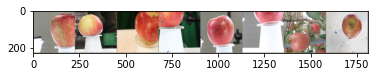

['Sweet_B_grade', 'Sweet_A_grade', 'Sweet_C_grade', 'Sweet_B_grade', 'Sweet_B_grade', 'Sweet_C_grade', 'Sweet_C_grade', 'Sweet_A_grade']


In [ ]:
# transform 된 배치 이미지 시각화
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out)
print([class_names[x] for x in classes])

In [9]:
from tqdm import tqdm
# from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter()

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    # model = model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        # print(f"time per 1 epoch: {time.time() - since:.2f}")

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                # model.load_state_dict(model_state_dict)
                model.train()  # 모델을 학습 모드로 설정
            else:
                # model.load_state_dict(model_state_dict)
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            # writer.add_scalar("Loss/train", epoch_loss, epoch)
            # writer.add_scalar("Acc/train", epoch_acc, epoch)
            # wandb.log({'train_acc': epoch_acc, 'train_loss' : epoch_loss})

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                print("Update best acc! :", best_acc)
                best_model_wts = copy.deepcopy(model.state_dict())

       
        print()
        time.sleep(0.1)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    # wandb.log({'test_acc': best_acc})
    

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [18]:
train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 1.0665 Acc: 0.4949


  5%|▌         | 1/20 [10:45<3:24:28, 645.68s/it]

val Loss: 1.2170 Acc: 0.4334
Update best acc! : tensor(0.4334, device='cuda:0', dtype=torch.float64)

Epoch 1/19
----------
train Loss: 1.0475 Acc: 0.5043


 10%|█         | 2/20 [21:31<3:13:44, 645.80s/it]

val Loss: 1.2510 Acc: 0.4573
Update best acc! : tensor(0.4573, device='cuda:0', dtype=torch.float64)

Epoch 2/19
----------
train Loss: 1.0323 Acc: 0.5038


 15%|█▌        | 3/20 [32:16<3:02:50, 645.33s/it]

val Loss: 1.2026 Acc: 0.4334

Epoch 3/19
----------
train Loss: 1.0333 Acc: 0.5014


 20%|██        | 4/20 [43:01<2:52:03, 645.21s/it]

val Loss: 1.1361 Acc: 0.4393

Epoch 4/19
----------
train Loss: 1.0315 Acc: 0.5050


 25%|██▌       | 5/20 [53:43<2:41:01, 644.11s/it]

val Loss: 1.2648 Acc: 0.4280

Epoch 5/19
----------
train Loss: 1.0284 Acc: 0.5050


 30%|███       | 6/20 [1:04:27<2:30:17, 644.13s/it]

val Loss: 1.2019 Acc: 0.4506

Epoch 6/19
----------
train Loss: 1.0225 Acc: 0.5058


 35%|███▌      | 7/20 [1:15:06<2:19:12, 642.53s/it]

val Loss: 1.2203 Acc: 0.4535

Epoch 7/19
----------
train Loss: 1.0169 Acc: 0.5065


 40%|████      | 8/20 [1:25:46<2:08:20, 641.70s/it]

val Loss: 1.2374 Acc: 0.4468

Epoch 8/19
----------
train Loss: 1.0156 Acc: 0.5134


 45%|████▌     | 9/20 [1:36:29<1:57:40, 641.90s/it]

val Loss: 1.2603 Acc: 0.4477

Epoch 9/19
----------
train Loss: 1.0076 Acc: 0.5189


 50%|█████     | 10/20 [1:47:11<1:47:00, 642.03s/it]

val Loss: 1.1996 Acc: 0.4523

Epoch 10/19
----------
train Loss: 0.9991 Acc: 0.5206


 55%|█████▌    | 11/20 [1:57:55<1:36:22, 642.50s/it]

val Loss: 1.1923 Acc: 0.4493

Epoch 11/19
----------
train Loss: 0.9967 Acc: 0.5164


 60%|██████    | 12/20 [2:08:38<1:25:41, 642.69s/it]

val Loss: 1.1779 Acc: 0.4514

Epoch 12/19
----------
train Loss: 0.9941 Acc: 0.5275


 65%|██████▌   | 13/20 [2:19:21<1:14:59, 642.84s/it]

val Loss: 1.2071 Acc: 0.4644
Update best acc! : tensor(0.4644, device='cuda:0', dtype=torch.float64)

Epoch 13/19
----------
train Loss: 0.9938 Acc: 0.5221


 70%|███████   | 14/20 [2:30:06<1:04:20, 643.50s/it]

val Loss: 1.2430 Acc: 0.4594

Epoch 14/19
----------
train Loss: 0.9907 Acc: 0.5233


 75%|███████▌  | 15/20 [2:40:45<53:31, 642.31s/it]  

val Loss: 1.2054 Acc: 0.4569

Epoch 15/19
----------
train Loss: 0.9898 Acc: 0.5263


 80%|████████  | 16/20 [2:51:31<42:53, 643.34s/it]

val Loss: 1.1969 Acc: 0.4460

Epoch 16/19
----------
train Loss: 0.9942 Acc: 0.5220


 85%|████████▌ | 17/20 [3:02:15<32:10, 643.57s/it]

val Loss: 1.1995 Acc: 0.4615

Epoch 17/19
----------
train Loss: 0.9946 Acc: 0.5262


 90%|█████████ | 18/20 [3:12:59<21:27, 643.58s/it]

val Loss: 1.2102 Acc: 0.4497

Epoch 18/19
----------
train Loss: 0.9888 Acc: 0.5241


 95%|█████████▌| 19/20 [3:23:43<10:43, 643.69s/it]

val Loss: 1.1929 Acc: 0.4560

Epoch 19/19
----------
train Loss: 0.9905 Acc: 0.5179


100%|██████████| 20/20 [3:34:27<00:00, 643.38s/it]

val Loss: 1.2046 Acc: 0.4535

Training complete in 214m 28s
Best val Acc: 0.464405


DeepGCN(
  (stem): Stem(
    (convs): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
      (3): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU()
      (6): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (backbone): Sequential(
    (0): Sequential(
      (0): Grapher(
        (fc1): Sequential(
          (0): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (graph_conv): DyGraphConv2d(
          (gconv): MRConv2d(
            (nn): BasicConv(
              (0): Conv2d(96, 96, kernel_s

In [19]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [20]:
# from torchsummary import summary

model = pvig_s_224()
model.prediction[4] = Conv2d(1024, len(class_names), kernel_size=(1,1), stride=(1,1))
# print(model)
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.95)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
# summary(model, (3, 224, 224))
train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=20)

<__main__.pvig_s_224.<locals>.OptInit object at 0x7f3ced7048e0>
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos


/tmp/ipykernel_62902/3354495458.py:74: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  omega = np.arange(embed_dim // 2, dtype=np.float)


using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 1.2484 Acc: 0.4488


  5%|▌         | 1/20 [05:04<1:36:29, 304.69s/it]

val Loss: 1.1406 Acc: 0.4481
Update best acc! : tensor(0.4481, device='cuda:0', dtype=torch.float64)

Epoch 1/19
----------
train Loss: 1.0874 Acc: 0.4829


 10%|█         | 2/20 [10:10<1:31:34, 305.27s/it]

val Loss: 1.1253 Acc: 0.4602
Update best acc! : tensor(0.4602, device='cuda:0', dtype=torch.float64)

Epoch 2/19
----------
train Loss: 1.0641 Acc: 0.4886


 15%|█▌        | 3/20 [15:14<1:26:17, 304.55s/it]

val Loss: 1.0830 Acc: 0.4577

Epoch 3/19
----------
train Loss: 1.0570 Acc: 0.4962


 20%|██        | 4/20 [20:16<1:21:02, 303.89s/it]

val Loss: 1.2529 Acc: 0.4644
Update best acc! : tensor(0.4644, device='cuda:0', dtype=torch.float64)

Epoch 4/19
----------
train Loss: 1.0437 Acc: 0.4934


 25%|██▌       | 5/20 [25:19<1:15:50, 303.33s/it]

val Loss: 1.2960 Acc: 0.4481

Epoch 5/19
----------
train Loss: 1.0377 Acc: 0.5014


 30%|███       | 6/20 [30:22<1:10:47, 303.37s/it]

val Loss: 1.1397 Acc: 0.4569

Epoch 6/19
----------
train Loss: 1.0359 Acc: 0.5014


 35%|███▌      | 7/20 [35:24<1:05:38, 302.95s/it]

val Loss: 1.2245 Acc: 0.4493

Epoch 7/19
----------
train Loss: 1.0311 Acc: 0.4954


 40%|████      | 8/20 [40:26<1:00:32, 302.67s/it]

val Loss: 1.3718 Acc: 0.4598

Epoch 8/19
----------
train Loss: 1.0233 Acc: 0.5073


 45%|████▌     | 9/20 [45:30<55:33, 303.07s/it]  

val Loss: 1.1625 Acc: 0.4682
Update best acc! : tensor(0.4682, device='cuda:0', dtype=torch.float64)

Epoch 9/19
----------
train Loss: 1.0179 Acc: 0.5090


 50%|█████     | 10/20 [50:34<50:31, 303.14s/it]

val Loss: 1.2150 Acc: 0.4631

Epoch 10/19
----------
train Loss: 0.9964 Acc: 0.5181


 55%|█████▌    | 11/20 [55:37<45:27, 303.07s/it]

val Loss: 1.2901 Acc: 0.4573

Epoch 11/19
----------
train Loss: 0.9953 Acc: 0.5238


 60%|██████    | 12/20 [1:00:42<40:29, 303.66s/it]

val Loss: 1.1977 Acc: 0.4665

Epoch 12/19
----------
train Loss: 0.9873 Acc: 0.5272


 65%|██████▌   | 13/20 [1:05:45<35:25, 303.57s/it]

val Loss: 1.2313 Acc: 0.4682

Epoch 13/19
----------
train Loss: 0.9933 Acc: 0.5236


 70%|███████   | 14/20 [1:10:47<30:18, 303.04s/it]

val Loss: 1.2356 Acc: 0.4577

Epoch 14/19
----------
train Loss: 0.9831 Acc: 0.5181


 75%|███████▌  | 15/20 [1:15:50<25:15, 303.13s/it]

val Loss: 1.2683 Acc: 0.4606

Epoch 15/19
----------
train Loss: 0.9788 Acc: 0.5241


 80%|████████  | 16/20 [1:20:55<20:14, 303.67s/it]

val Loss: 1.2135 Acc: 0.4627

Epoch 16/19
----------
train Loss: 0.9818 Acc: 0.5374


 85%|████████▌ | 17/20 [1:25:58<15:10, 303.52s/it]

val Loss: 1.2039 Acc: 0.4598

Epoch 17/19
----------
train Loss: 0.9821 Acc: 0.5273


 90%|█████████ | 18/20 [1:31:06<10:09, 304.84s/it]

val Loss: 1.2316 Acc: 0.4669

Epoch 18/19
----------
train Loss: 0.9881 Acc: 0.5273


 95%|█████████▌| 19/20 [1:36:11<05:04, 304.79s/it]

val Loss: 1.2966 Acc: 0.4619

Epoch 19/19
----------
train Loss: 0.9815 Acc: 0.5250


100%|██████████| 20/20 [1:41:12<00:00, 303.63s/it]

val Loss: 1.2633 Acc: 0.4606

Training complete in 101m 13s
Best val Acc: 0.468174


DeepGCN(
  (stem): Stem(
    (convs): Sequential(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
      (3): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU()
      (6): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (backbone): Sequential(
    (0): Sequential(
      (0): Grapher(
        (fc1): Sequential(
          (0): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (graph_conv): DyGraphConv2d(
          (gconv): MRConv2d(
            (nn): BasicConv(
              (0): Conv2d(160, 160, kernel

In [13]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [18]:
# from torchsummary import summary

model = pvig_m_224_LPE(pretrained=True)
model.prediction[4] = Conv2d(1024, len(class_names), kernel_size=(1,1), stride=(1,1))
# print(model)
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.95)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
# summary(model, (3, 224, 224))
train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=20)

<__main__.pvig_m_224_LPE.<locals>.OptInit object at 0x7f7a43cbc0d0>
using Learnable Positional Embedding
using Learnable Positional Embedding
using Learnable Positional Embedding
using Learnable Positional Embedding
using Learnable Positional Embedding
using Learnable Positional Embedding
using Learnable Positional Embedding
using Learnable Positional Embedding
using Learnable Positional Embedding
using Learnable Positional Embedding
using Learnable Positional Embedding
using Learnable Positional Embedding
using Learnable Positional Embedding
using Learnable Positional Embedding
using Learnable Positional Embedding


/tmp/ipykernel_85686/3354495458.py:74: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  omega = np.arange(embed_dim // 2, dtype=np.float)


using Learnable Positional Embedding
using Learnable Positional Embedding
using Learnable Positional Embedding
using Learnable Positional Embedding
using Learnable Positional Embedding
using Learnable Positional Embedding
using Learnable Positional Embedding


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 1.2340 Acc: 0.4410


  5%|▌         | 1/20 [11:50<3:44:52, 710.11s/it]

val Loss: 1.2559 Acc: 0.4221
Update best acc! : tensor(0.4221, device='cuda:0', dtype=torch.float64)

Epoch 1/19
----------
train Loss: 1.0923 Acc: 0.4871


 10%|█         | 2/20 [23:40<3:33:02, 710.12s/it]

val Loss: 1.1087 Acc: 0.4104

Epoch 2/19
----------
train Loss: 1.0610 Acc: 0.4858


 15%|█▌        | 3/20 [35:29<3:21:09, 709.94s/it]

val Loss: 1.1091 Acc: 0.4493
Update best acc! : tensor(0.4493, device='cuda:0', dtype=torch.float64)

Epoch 3/19
----------
train Loss: 1.0557 Acc: 0.4918


 20%|██        | 4/20 [47:19<3:09:18, 709.92s/it]

val Loss: 1.1081 Acc: 0.4389

Epoch 4/19
----------
train Loss: 1.0540 Acc: 0.4895


 25%|██▌       | 5/20 [59:09<2:57:24, 709.64s/it]

val Loss: 1.1112 Acc: 0.4472

Epoch 5/19
----------
train Loss: 1.0454 Acc: 0.4935


 30%|███       | 6/20 [1:10:59<2:45:37, 709.82s/it]

val Loss: 1.0987 Acc: 0.4527
Update best acc! : tensor(0.4527, device='cuda:0', dtype=torch.float64)

Epoch 6/19
----------
train Loss: 1.0386 Acc: 0.4962


 35%|███▌      | 7/20 [1:22:47<2:33:43, 709.47s/it]

val Loss: 1.1308 Acc: 0.4497

Epoch 7/19
----------
train Loss: 1.0320 Acc: 0.5031


 40%|████      | 8/20 [1:34:38<2:21:58, 709.92s/it]

val Loss: 1.1246 Acc: 0.4648
Update best acc! : tensor(0.4648, device='cuda:0', dtype=torch.float64)

Epoch 8/19
----------
train Loss: 1.0280 Acc: 0.4999


 45%|████▌     | 9/20 [1:46:26<2:10:02, 709.30s/it]

val Loss: 1.2877 Acc: 0.4343

Epoch 9/19
----------
train Loss: 1.0231 Acc: 0.5008


 50%|█████     | 10/20 [1:58:15<1:58:11, 709.13s/it]

val Loss: 1.1199 Acc: 0.4606

Epoch 10/19
----------
train Loss: 0.9961 Acc: 0.5225


 55%|█████▌    | 11/20 [2:10:05<1:46:24, 709.34s/it]

val Loss: 1.0989 Acc: 0.4535

Epoch 11/19
----------
train Loss: 0.9907 Acc: 0.5280


 60%|██████    | 12/20 [2:21:57<1:34:41, 710.17s/it]

val Loss: 1.1698 Acc: 0.4523

Epoch 12/19
----------
train Loss: 0.9944 Acc: 0.5245


 65%|██████▌   | 13/20 [2:33:45<1:22:47, 709.63s/it]

val Loss: 1.2655 Acc: 0.4485

Epoch 13/19
----------
train Loss: 0.9867 Acc: 0.5262


 70%|███████   | 14/20 [2:45:34<1:10:56, 709.34s/it]

val Loss: 1.1752 Acc: 0.4502

Epoch 14/19
----------
train Loss: 0.9896 Acc: 0.5275


 75%|███████▌  | 15/20 [2:57:22<59:04, 708.93s/it]  

val Loss: 1.1736 Acc: 0.4527

Epoch 15/19
----------


 75%|███████▌  | 15/20 [2:58:53<59:37, 715.54s/it]


KeyboardInterrupt: 

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# from torchsummary import summary

model = pvig_b_224_LPE(pretrained=True)
model.prediction[4] = Conv2d(1024, len(class_names), kernel_size=(1,1), stride=(1,1))
# print(model)
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.95)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
# summary(model, (3, 224, 224))
train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=20)